In [ ]:
import numpy as np
import pandas as pd
import os
import time
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import Callback, EarlyStopping
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras import regularizers
import matplotlib.pyplot as plt
import seaborn as sns


# Przygotowanie danych

In [ ]:
def define_paths(dir):
    filepaths = []
    labels = []

    for root, _, files in os.walk(dir):
        for file in files:
            filepaths.append(os.path.join(root, file))
            labels.append(os.path.basename(root))

    return filepaths, labels

def create_df(data_dir):
    files, classes = define_paths(data_dir)
    df = pd.DataFrame({'filepaths': files, 'labels': classes})

    strat = df['labels']
    train_df, dummy_df = train_test_split(df, train_size=0.7, shuffle=True, random_state=123, stratify=strat)

    strat = dummy_df['labels']
    valid_df, test_df = train_test_split(dummy_df, train_size=0.5, shuffle=True, random_state=123, stratify=strat)

    return train_df, valid_df, test_df


In [ ]:
def create_image_data_generator(train_df, valid_df, test_df, batch_size):

    image_size = (224, 224)
    color = 'rgb'
    
    ts_len = len(test_df)
    test_batch_size = max(sorted([ts_len // n for n in range(1, ts_len + 1) if ts_len % n == 0 and ts_len / n <= 80]))

    def preprocess_image(image):
        return image


    train_data_generator = ImageDataGenerator(preprocessing_function=preprocess_image, horizontal_flip=True)
    test_data_generator = ImageDataGenerator(preprocessing_function=preprocess_image)

    train_generator = train_data_generator.flow_from_dataframe(train_df, x_col='filepaths', y_col='labels', target_size=image_size, class_mode='categorical',
                                                               color_mode=color, shuffle=True, batch_size=batch_size)

    valid_generator = test_data_generator.flow_from_dataframe(valid_df, x_col='filepaths', y_col='labels', target_size=image_size, class_mode='categorical',
                                                             color_mode=color, shuffle=True, batch_size=batch_size)

    test_generator = test_data_generator.flow_from_dataframe(test_df, x_col='filepaths', y_col='labels', target_size=image_size, class_mode='categorical',
                                                            color_mode=color, shuffle=False, batch_size=test_batch_size)

    return train_generator, valid_generator, test_generator


In [ ]:
class CustomCallback(Callback):
    def __init__(self, patience=3):
        super(CustomCallback, self).__init__()
        self.patience = patience
        self.wait_epochs = 0

    def on_epoch_begin(self, epoch, logs=None):
        self.epoch_start_time = time.time()
        self.pbar = tqdm(total=self.params['steps'], desc=f'Epoch {epoch + 1}/{self.params["epochs"]}', unit='batch')

    def on_epoch_end(self, epoch, logs=None):
        train_accuracy = logs.get('accuracy')
        val_accuracy = logs.get('val_accuracy')

        print(f'Epoch {epoch + 1} - Training Accuracy: {train_accuracy:.4f} - Validation Accuracy: {val_accuracy:.4f}')
        self.pbar.close()

    def on_batch_end(self, batch, logs=None):
        self.pbar.update(1)

    def on_epoch_end(self, epoch, logs=None):
        val_accuracy = logs.get('val_accuracy')

        if epoch > 0 and val_accuracy <= self.best_val_accuracy:
            self.wait_epochs += 1
            if self.wait_epochs >= self.patience:
                print(f'Early stopping! No improvement in validation accuracy for {self.patience} epochs.')
                self.model.stop_training = True
        else:
            self.best_val_accuracy = val_accuracy
            self.wait_epochs = 0
            self.model.save(f'model_self_impl_epoch_{epoch + 1}.h5')

custom_callback = CustomCallback()
early_stopping = EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)

In [ ]:
data_dir = "/Users/michallupa/Downloads/Praca Inżynierska/Final models/C-NMC_Leukemia/training_data"
batch_size = 40

train_df, valid_df, test_df = create_df(data_dir)

train_gen, valid_gen, test_gen = create_image_data_generator(train_df, valid_df, test_df, batch_size)

In [ ]:
images, labels = train_gen.next()
class_img = list(train_gen.class_indices.keys())

fig, axes = plt.subplots(1, 1, figsize=(15, 3))

for i in range(1):
    image = images[i] / 255  
    plt.imshow(image)
    index = np.argmax(labels[i])
    plt.axis('off') 
    plt.title(class_img[index], color= 'black', fontsize= 15)

plt.show()

# Self Implemented

In [ ]:
model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(Dropout(0.6)) 
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))  
model.add(Dense(2, activation='softmax'))  

model.compile(optimizer='adamax', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

In [ ]:
log_dir = os.path.join("logs_self_imp", "fit")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

In [ ]:
batch_size = 40   
epochs = 50   
patience = 1 

In [ ]:
history = model.fit(x= train_gen, epochs= epochs, verbose= 0, callbacks= [custom_callback,tensorboard_callback,early_stopping],
                    validation_data= valid_gen, validation_steps= 1, shuffle= False)

# ResNet50

In [ ]:
base_model = ResNet50(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
class_count =  2
input_layer = Input(shape=(224, 224, 3))

x = base_model(input_layer)

x = BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001)(x)
x = Flatten()(x)
x = Dense(256, kernel_regularizer=regularizers.l2(l=0.016), 
          activity_regularizer=regularizers.l1(0.006),
          bias_regularizer=regularizers.l1(0.006), activation='relu')(x)
x = Dropout(rate=0.45, seed=42)(x)


output_layer = Dense(class_count, activation='softmax')(x)

model = Model(inputs=input_layer, outputs=output_layer)

model.compile(Adamax(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()


In [ ]:
log_dir = os.path.join("ResNet/logs_my_ResNet50", "fit")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

In [ ]:
history = model.fit(x= train_gen, epochs= epochs, verbose= 0, callbacks= [custom_callback,tensorboard_callback,early_stopping],
                    validation_data= valid_gen, validation_steps= 1, shuffle= False)

# EfficientNetB3

In [ ]:
img_shape = (224, 224, 3)
class_count = 2

base_model = tf.keras.applications.efficientnet.EfficientNetB5(include_top= False, weights= "imagenet", input_shape= img_shape, pooling= 'max')

model = Sequential([
    base_model,
    BatchNormalization(axis= -1, momentum= 0.99, epsilon= 0.001),
    Dense(256, kernel_regularizer= regularizers.l2(l= 0.012), activity_regularizer= regularizers.l1(0.007),
                bias_regularizer= regularizers.l1(0.007), activation= 'relu'),
    Dropout(rate= 0.55, seed= 42),
    Dense(class_count, activation= 'softmax')
])

model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

model.summary()

In [ ]:
log_dir = os.path.join("ENETB3/logs_my_ENETB3", "fit")

In [ ]:
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

In [ ]:
history = model.fit(x= train_gen, epochs= epochs, verbose= 0, callbacks= [custom_callback,tensorboard_callback,early_stopping],
                    validation_data= valid_gen, validation_steps= 1, shuffle= False)

# EfficientNetB5

In [ ]:
img_shape = (224, 224, 3)
class_count = 2

base_model = tf.keras.applications.efficientnet.EfficientNetB5(include_top= False, weights= "imagenet", input_shape= img_shape, pooling= 'max')

model = Sequential([
    base_model,
    BatchNormalization(axis= -1, momentum= 0.99, epsilon= 0.001),
    Dense(256, kernel_regularizer= regularizers.l2(l= 0.02), activity_regularizer= regularizers.l1(0.01),
                bias_regularizer= regularizers.l1(0.01), activation= 'relu'),
    Dropout(rate= 0.6, seed= 42),
    Dense(class_count, activation= 'softmax')
])

model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

model.summary()

In [ ]:
log_dir = os.path.join("ENETB5/logs_my_ENET5", "fit")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

In [ ]:
history = model.fit(x= train_gen, epochs= epochs, verbose= 0, callbacks= [custom_callback,tensorboard_callback,early_stopping],
                    validation_data= valid_gen, validation_steps= 1, shuffle= False)

# Rezultat dla najlepszego modelu EfficientNetB3 po 11 epoce

In [103]:
model = tf.keras.models.load_model('FINAL_model_ENETB3_11.h5')

In [104]:
ts_len = len(test_df)
test_batch_size = max(sorted([ts_len // n for n in range(1, ts_len + 1) if ts_len % n == 0 and ts_len / n <= 80]))
test_steps = ts_len // test_batch_size

trening_result = model.evaluate(train_gen, steps=test_steps, verbose=1)
validation_result = model.evaluate(valid_gen, steps=test_steps, verbose=1)
test_result = model.evaluate(test_gen, steps=test_steps, verbose=1)
print('\n')
print("Strata na zbiorze treningowym: ", trening_result[0])
print("Dokładność na zbiorze treningowym: ", trening_result[1])
print('\n')
print("Strata na zbiorze walidacyjnym: ", validation_result[0])
print("Dokładność na zbiorze walidacyjnym: ", validation_result[1])
print('\n')
print("Strata na zbiorze testowym: ", test_result[0])
print("Dokładność na zbiorze testowym: ", test_result[1])


20/20 [==============================] - 30s 1s/step - loss: 0.2306 - accuracy: 0.9600


Strata na zbiorze treningowym:  0.1331900805234909
Dokładność na zbiorze treningowym:  0.9962499737739563


Strata na zbiorze walidacyjnym:  0.24411828815937042
Dokładność na zbiorze walidacyjnym:  0.9549999833106995


Strata na zbiorze testowym:  0.2306193709373474
Dokładność na zbiorze testowym:  0.9599999785423279


# Macierz błędu

In [105]:
predictions = model.predict_generator(test_gen)
y_predicted = np.argmax(predictions, axis=1)

g_dict = test_gen.class_indices
classes = list(g_dict.keys())
plt.rc('font', size=16)

cm = confusion_matrix(test_gen.classes, y_predicted)


/var/folders/m0/2t7xmlf97qs84k0mg35df01c0000gn/T/ipykernel_2334/1273331605.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predictions = model.predict_generator(test_gen)


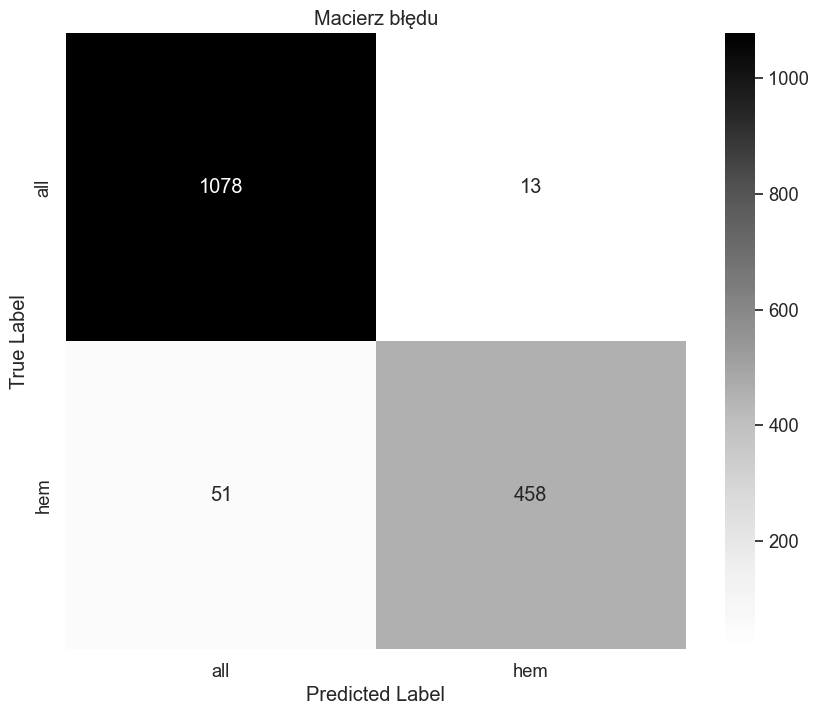

In [106]:
class_names = list(test_gen.class_indices.keys())

plt.figure(figsize=(10, 8))
sns.set(font_scale=1.2)
sns.heatmap(cm, annot=True, fmt="d", cmap="Greys", xticklabels=class_names, yticklabels=class_names)
plt.title('Macierz błędu')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()